In [5]:
import os
import glob
import nibabel as nib
import numpy as np
import cv2
import math

import matplotlib.pyplot as plt
import plotly.express as px

In [6]:
data_path = '../data/all/VS-1-30'
scan_path = os.path.join(data_path, 'vs_gk_11')

t1_path = glob.glob(os.path.join(scan_path, '*_t1_*'))[0]
t2_path = glob.glob(os.path.join(scan_path, '*_t2_*'))[0]
seg_path = glob.glob(os.path.join(scan_path, '*_seg_*'))[0]
print(t1_path)

../data/all/VS-1-30/vs_gk_11/vs_gk_t1_refT2.nii.gz


In [7]:
t1 = nib.load(t1_path).get_fdata()
t2 = nib.load(t2_path).get_fdata()
seg = nib.load(seg_path).get_fdata()

seg.shape

(448, 448, 80)

In [8]:
seg2 = nib.load(seg_path).get_fdata()
seg2[20:100, 20:100, 20] = 2
seg2[200:400, 20:100, 20] = 3

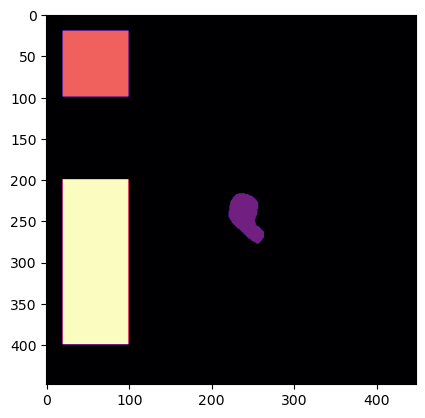

In [9]:
plt.imshow(seg2[:,:,20], cmap='magma')

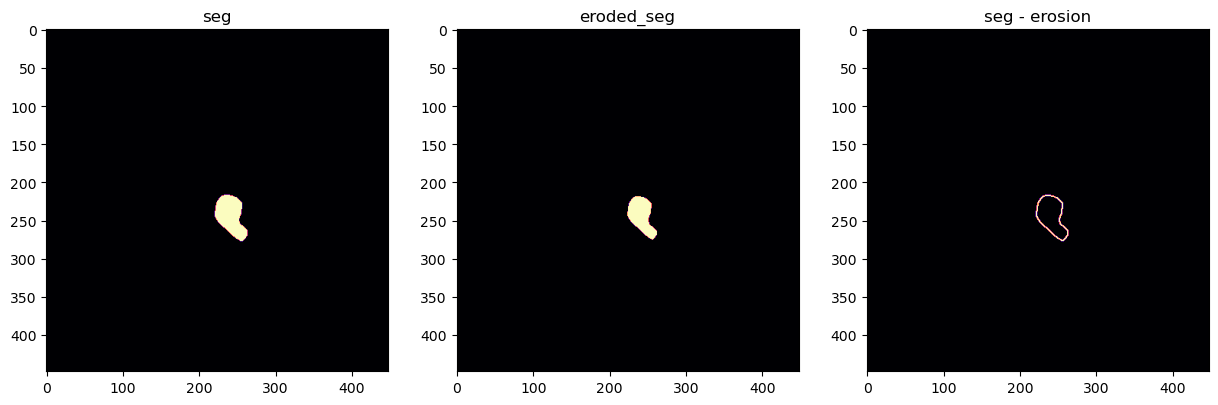

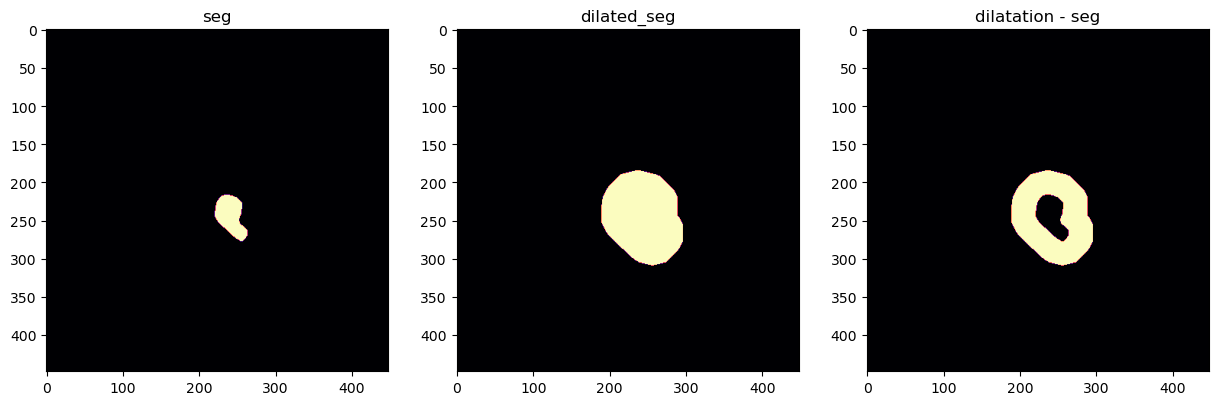

In [10]:
slice = 20

erosion_kernel = cv2.getStructuringElement(shape=cv2.MORPH_ELLIPSE, ksize=(5, 5))
dilatation_kernel = cv2.getStructuringElement(shape=cv2.MORPH_ELLIPSE, ksize=(17, 17))
eroded_seg = cv2.erode(seg[:,:,slice], kernel=erosion_kernel)
dilated_seg = cv2.dilate(seg[:,:,slice], kernel=dilatation_kernel, iterations=4)

diff = seg[:,:,slice] - eroded_seg
diff2 = dilated_seg - seg[:,:,slice]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 10))
ax1.imshow(seg[:,:,slice], cmap = 'magma')
ax1.set_title('seg')
ax2.imshow(eroded_seg, cmap='magma')
ax2.set_title('eroded_seg')
ax3.imshow(diff, cmap='magma')
ax3.set_title('seg - erosion')
plt.show()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 10))
ax1.imshow(seg[:,:,slice], cmap = 'magma')
ax1.set_title('seg')
ax2.imshow(dilated_seg, cmap='magma')
ax2.set_title('dilated_seg')
ax3.imshow(diff2, cmap='magma')
ax3.set_title('dilatation - seg')
plt.show()

In [11]:
border_idx = np.where(diff == 1)
print(border_idx[0][:10])
print(border_idx[1][:10])

border_coords = list(zip(*border_idx))
print(border_coords[:10])

[217 217 217 217 217 217 217 217 218 218]
[233 234 235 236 237 238 239 240 230 231]
[(217, 233), (217, 234), (217, 235), (217, 236), (217, 237), (217, 238), (217, 239), (217, 240), (218, 230), (218, 231)]


In [12]:
inner_idx = np.where(seg[:,:,slice] == 1)
inner_coords = list(zip(*inner_idx))
inner_coords = list(set(inner_coords) - set(border_coords))
np.random.shuffle(inner_coords)

outer_idx = np.where(diff2 == 1)
outer_coords = list(zip(*outer_idx))
outer_coords = list(set(outer_coords) - set(inner_coords))
np.random.shuffle(outer_coords)

In [13]:
b = nib.load(seg_path).get_fdata()
for c in outer_coords:
    b[c[0], c[1], slice] = 2

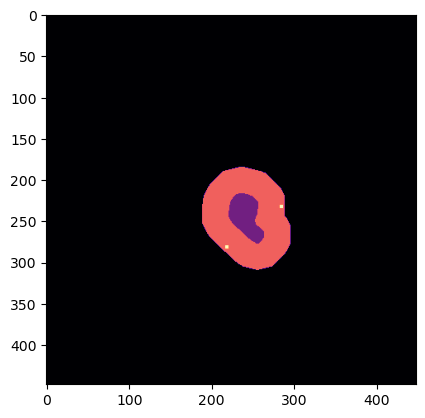

In [14]:
for c in outer_coords[:2]:
    b[c[0]:c[0]+4, c[1]:c[1]+4, slice] = 3
plt.imshow(b[:,:,slice], cmap='magma')

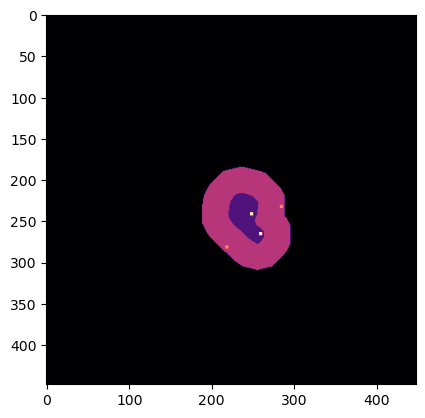

In [15]:
for c in inner_coords[:2]:
    b[c[0]:c[0]+4, c[1]:c[1]+4, slice] = 4
plt.imshow(b[:,:,slice], cmap='magma')

In [16]:
outer_clicks = list(zip(*np.where(b[:,:,slice] == 4)))
print(len(outer_clicks))
outer_clicks

32


[(240, 247),
 (240, 248),
 (240, 249),
 (240, 250),
 (241, 247),
 (241, 248),
 (241, 249),
 (241, 250),
 (242, 247),
 (242, 248),
 (242, 249),
 (242, 250),
 (243, 247),
 (243, 248),
 (243, 249),
 (243, 250),
 (264, 258),
 (264, 259),
 (264, 260),
 (264, 261),
 (265, 258),
 (265, 259),
 (265, 260),
 (265, 261),
 (266, 258),
 (266, 259),
 (266, 260),
 (266, 261),
 (267, 258),
 (267, 259),
 (267, 260),
 (267, 261)]

In [17]:
fig = px.imshow(b[:,:,slice])
fig.update_coloraxes(
    showscale=False,
    colorscale=[
        (0.0, 'black'),
        (0.25, 'rgb(251, 252, 197)'),
        (0.5, 'rgb(245, 212, 66)'),
        (0.75, 'blue'),
        (1, 'red'),
    ],
)
fig.show()

In [18]:
b = nib.load(seg_path).get_fdata()
for c in outer_coords:
    b[c[0], c[1], slice] = 2

In [19]:
for c in inner_coords[:10]:
    b[c[0]:c[0]+2, c[1]:c[1]+2, slice] = 4

In [20]:
fig = px.imshow(b[:,:,slice])
fig.update_coloraxes(
    showscale=False,
    colorscale=[
        (0.0, 'black'),
        (0.25, 'rgb(251, 252, 197)'),
        (0.5, 'rgb(245, 212, 66)'),
        (0.75, 'blue'),
        (1, 'red'),
    ],
)
fig.show()

## 3d

In [21]:
def get_glioma_indices(mask) -> tuple[int, int]:
    """ Returns the first and last slice indices of the tumour in given mask """

    first = sorted(np.nonzero((mask == 1))[2])[0]
    last = sorted(np.nonzero((mask == 1))[2])[-1]

    return first, last

In [45]:
def generate_clicks(mask, fg=False, bg=False, click_size=2):
    clicks = {
        'slices': [],
    }

    first, last = get_glioma_indices(mask)

    for slice in range(first, last):
        erosion_kernel = cv2.getStructuringElement(shape=cv2.MORPH_ELLIPSE, ksize=(5, 5))
        dilatation_kernel = cv2.getStructuringElement(shape=cv2.MORPH_ELLIPSE, ksize=(17, 17))
        eroded_seg = cv2.erode(mask[:,:,slice], kernel=erosion_kernel)
        dilated_seg = cv2.dilate(mask[:,:,slice], kernel=dilatation_kernel, iterations=4)

        diff = mask[:,:,slice] - eroded_seg
        diff2 = dilated_seg - mask[:,:,slice]

        border_idx = np.where(diff == 1)
        # print(border_idx[0][:10])
        # print(border_idx[1][:10])

        border_coords = list(zip(*border_idx))
        # print(border_coords[:10])

        # Get fg coordinates
        inner_idx = np.where(mask[:,:,slice] == 1)
        inner_coords = list(zip(*inner_idx))
        inner_coords = list(set(inner_coords) - set(border_coords))
        np.random.shuffle(inner_coords)
        
        # Get bg coordinates
        outer_idx = np.where(diff2 == 1)
        outer_coords = list(zip(*outer_idx))
        outer_coords = list(set(outer_coords) - set(inner_coords))
        np.random.shuffle(outer_coords)


        slice_clicks = {
            'slice': slice,
            'fg_clicks': [],
            'bg_clicks': []
        }

        # Add bg clicks
        if bg:
            for c in outer_coords[:2]:
                slice_clicks['bg_clicks'].append({'y': int(c[0]), 'x': int(c[1])})
                mask[c[0]:c[0]+click_size, c[1]:c[1]+click_size, slice] = 3
        # plt.imshow(b[:,:,slice], cmap='magma')

        # Add fg clicks
        if fg:
            for c in inner_coords[:2]:
                slice_clicks['fg_clicks'].append({'y': int(c[0]), 'x': int(c[1])})
                mask[c[0]:c[0]+click_size, c[1]:c[1]+click_size, slice] = 4
        # plt.imshow(b[:,:,slice], cmap='magma')
    
        clicks['slices'].append(slice_clicks)

    return mask, clicks


In [46]:
def plot_tumour(mask):
    # Compute number of slices with the tumour
    first, last = get_glioma_indices(mask)
    length = (last-first+1)
    n_graphs = (length)//4
    rows = n_graphs
    cols = 4
    res = cols if cols > rows else rows

    # Plot them
    fig, axs = plt.subplots(rows, cols, figsize=(res*2, res*2))
    axs = axs.flatten()
    j = 0
    for i in range(first, last):
        if j >= len(axs): break
        axs[j].imshow(mask[:,:,i], cmap='magma')
        axs[j].axis('off')
        axs[j].set_title(f'mask slice {i}', fontsize=9)
        j += 1

    plt.show()    

In [47]:
t1 = nib.load(t1_path).get_fdata()
t2 = nib.load(t2_path).get_fdata()
seg = nib.load(seg_path).get_fdata()

seg.shape

(448, 448, 80)

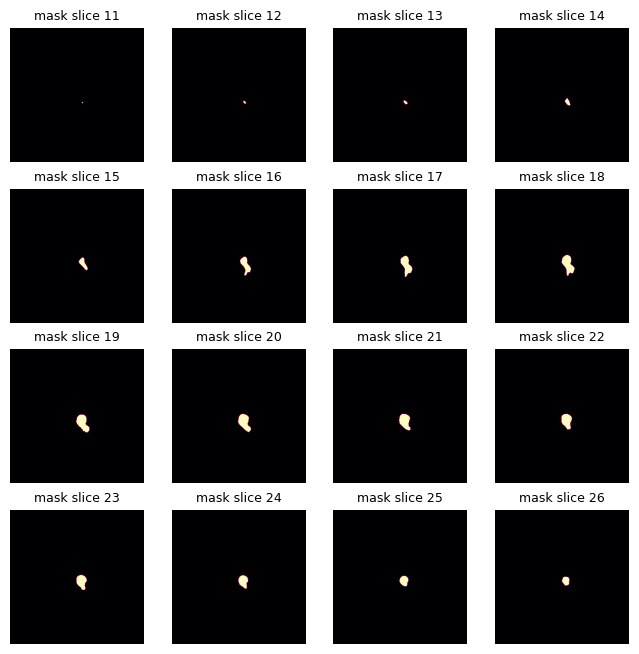

In [48]:
plot_tumour(seg)

In [49]:
new_mask, generated_clicks = generate_clicks(seg, fg=True, bg=True)

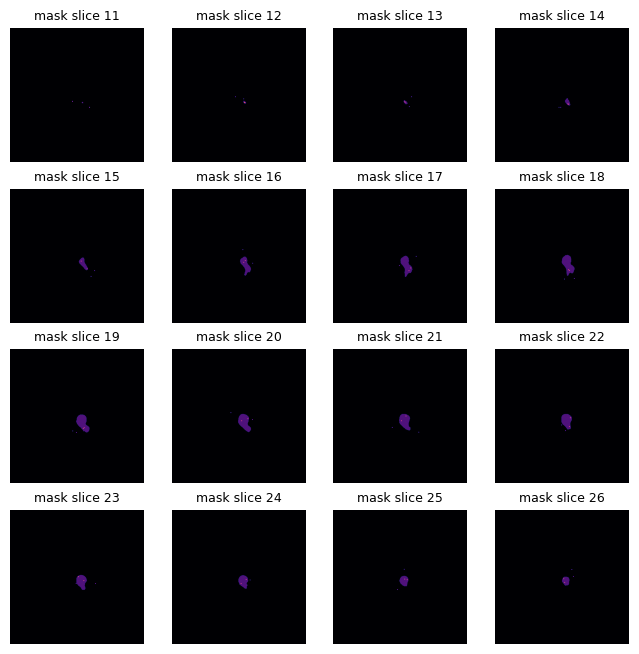

In [50]:
plot_tumour(new_mask)

In [51]:
clicks = {
    'images': [
        {
            'image': seg_path,
            'clicks': generated_clicks
        }
    ]
}

In [52]:
import json

In [53]:
with open('clicks.json', 'w') as f:
    json.dump(clicks, f)

In [54]:
slice = clicks['slices'][6]['slice']
x = clicks['slices'][1]['fg_clicks'][0]['x']
y = clicks['slices'][1]['fg_clicks'][0]['y']
print(slice, x, y)

KeyError: 'slices'

In [212]:
fig = px.imshow(seg[x-10:x+10, y-10:y+10, slice])
fig.update_coloraxes(
    showscale=False,
    colorscale=[
        (0.0, 'black'),
        (0.25, 'rgb(251, 252, 197)'),
        (0.5, 'rgb(245, 212, 66)'),
        (0.75, 'blue'),
        (1, 'red'),
    ],
)
fig.show()

In [213]:
fig = px.imshow(seg[:, :, slice])
fig.update_coloraxes(
    showscale=False,
    colorscale=[
        (0.0, 'black'),
        (0.25, 'rgb(251, 252, 197)'),
        (0.5, 'rgb(245, 212, 66)'),
        (0.75, 'blue'),
        (1, 'red'),
    ],
)
fig.show()

In [59]:
seg_list = sorted(glob.glob(os.path.join('../data/all/', 'VS-*-*/vs_*/*_seg_*')))
len(seg_list)

for seg_path in seg_list:
    seg = nib.load(seg_path).get_fdata()
    new_mask, generated_clicks = generate_clicks(seg, fg=True, bg=True)

    with open('clicks.json', 'a') as f:
        json.dump(clicks, f)
